In [1]:
import video_processing as vp
import numpy
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from roipoly import RoiPoly 
import matplotlib.animation as Animation

In [21]:
HEIGHT = 256
WIDTH = 256
TRUE_FRAMERATE = 28.815
IMAGING_FRAMERATE = 1/(34704.0/1e6)

date = '20180312'
directory = "./"
experiment = "Experiment_2"

subset_behaviour_file = 'D:/2_mice/20180312/Experiment_2/Behaviour/M803L_M804R_March-12_1524_experiment-2_wt_cage-mates_mouse_rail_together_12mm_subset_interpolated.raw'
l_mouse_processed_file = 'D:/2_mice/20180312/Experiment_2/LEFT_GREEN_processed__interp_dff0_bandpass0.01-3.0Hz_MM803L_March-12_1520_experiment-2_M804R_wt_cage-mates_mouse_rail_together_12mm.raw'
r_mouse_processed_file = 'D:/2_mice/20180312/Experiment_2/RIGHT_GREEN_processed__interp_dff0_bandpass0.01-3.0Hz_MM804R_March-12_1525_experiment-2_M803L_wt_cage-mates_mouse_rail_together_12mm.raw'
l_green_frame_file = 'D:/2_mice/20180312/Experiment_2/LEFT_RAW_GREEN_FRAME.npy'
r_green_frame_file = 'D:/2_mice/20180312/Experiment_2/RIGHT_RAW_GREEN_FRAME.npy'

In [9]:
l_green_frame = numpy.load(l_green_frame_file)
r_green_frame = numpy.load(r_green_frame_file)

## Load Calcium Imaging and Apply Gaussian Filter

In [ ]:
l_mouse_frames = vp.extract_RAW_frames(
    l_mouse_processed_file,
    WIDTH,
    HEIGHT, 
    dtype='float32',
    num_channels=1
)
l_mouse_frames[numpy.where(l_mouse_frames == -numpy.inf)] = -1

r_mouse_frames = vp.extract_RAW_frames(
    r_mouse_processed_file,
    WIDTH,
    HEIGHT, 
    dtype='float32',
    num_channels=1
)
r_mouse_frames[numpy.where(r_mouse_frames == -numpy.inf)] = -1

In [17]:
SIGMA = 2
for i, (l_mouse_frame, r_mouse_frame) in enumerate(
    zip(l_mouse_frames, r_mouse_frames)
):
    l_mouse_frames[i] = gaussian_filter(l_mouse_frame, SIGMA)
    r_mouse_frames[i] = gaussian_filter(r_mouse_frame, SIGMA)

## Behaviour Video

In [34]:
behaviour_frames = vp.extract_RAW_frames(
    subset_behaviour_file,
    width=320,
    height=180, 
    dtype='uint8',
    num_channels=1
)

10083 10083.0


## Mask Brains

([], <a list of 0 Text yticklabel objects>)

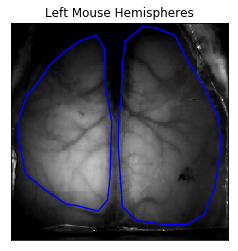

In [37]:
# Left mouse
plt.figure()

%matplotlib qt
plt.title('Left Mouse Left Hemisphere')
plt.imshow(l_green_frame, cmap='gray', vmin=0, vmax=150)
LM_left_hem = RoiPoly(color='b')
plt.title('Left Mouse Right Hemisphere')
plt.imshow(l_green_frame, cmap='gray', vmin=0, vmax=150)
LM_right_hem = RoiPoly(color='r')

%matplotlib inline
plt.title('Left Mouse Hemispheres')
plt.imshow(l_green_frame, cmap='gray', vmin=0, vmax=150)
LM_left_hem.display_roi()
LM_right_hem.display_roi()
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

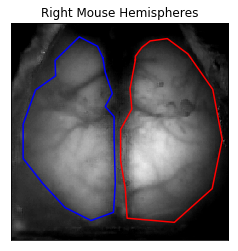

In [38]:
# Right mouse
plt.figure()

%matplotlib qt
plt.title('Right Mouse Left Hemisphere')
plt.imshow(r_green_frame, cmap='gray', vmin=0, vmax=150)
RM_left_hem = RoiPoly(color='b')
plt.title('Right Mouse Right Hemisphere')
plt.imshow(r_green_frame, cmap='gray', vmin=0, vmax=150)
RM_right_hem = RoiPoly(color='r')

%matplotlib inline
plt.title('Right Mouse Hemispheres')
plt.imshow(r_green_frame, cmap='gray', vmin=0, vmax=150)
RM_left_hem.display_roi()
RM_right_hem.display_roi()
plt.xticks([])
plt.yticks([])

## Plot the hemisphere masks

Text(0.5, 1.0, 'Right Mouse Mask')

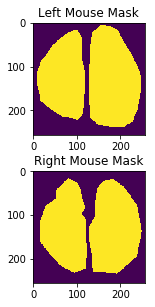

In [48]:
fig = plt.figure(figsize=(2,5))

ax = plt.subplot(2,1,1)
l_mouse_mask = numpy.logical_or(
    LM_left_hem.get_mask(l_mouse_frames[2000]),
    LM_right_hem.get_mask(l_mouse_frames[2000])
)    
ax.imshow(l_mouse_mask)
ax.set_title('Left Mouse Mask')

ax1 = plt.subplot(2,1,2)
r_mouse_mask = numpy.logical_or(
    RM_left_hem.get_mask(r_mouse_frames[2000]),
    RM_right_hem.get_mask(r_mouse_frames[2000])
)
ax1.imshow(r_mouse_mask)
ax1.set_title('Right Mouse Mask')

In [ ]:
numpy.save("l_mouse_mask.npy", l_mouse_mask)
numpy.save("r_mouse_mask.npy", r_mouse_mask)

## Select Behaviour ROI

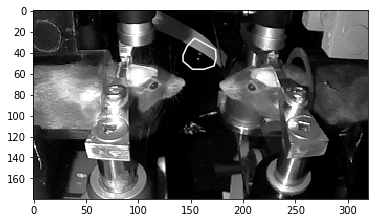

In [49]:
%matplotlib qt
plt.imshow(behaviour_frames[5000], cmap='gray', vmin=0, vmax=255)
grad_roi = RoiPoly(color='w')

%matplotlib inline
plt.imshow(behaviour_frames[5000], cmap='gray', vmin=0, vmax=255)
grad_roi.display_roi()

## Select the ROI to subtract from the behaviour ROI

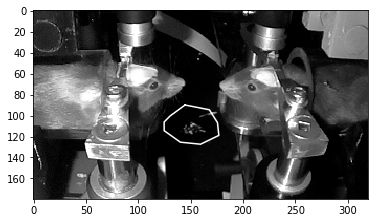

In [51]:
%matplotlib qt
plt.imshow(behaviour_frames[5000], cmap='gray', vmin=0, vmax=255)
subtract_grad_roi = RoiPoly(color='w')

%matplotlib inline
plt.imshow(behaviour_frames[5000], cmap='gray', vmin=0, vmax=255)
subtract_grad_roi.display_roi()

## Plot the ROI gradient signal and threshold

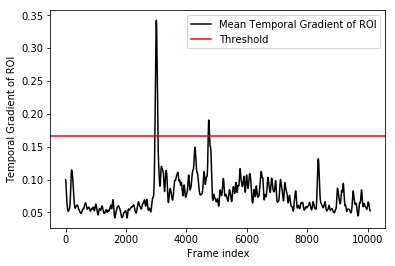

In [55]:
SIGMA=3
MIN_FRAME_THRESHOLD = 100
grad_mask = grad_roi.get_mask(behaviour_frames[0])
roi_gradient_signal = gaussian_filter(
    numpy.abs(
        numpy.gradient(
            numpy.mean(behaviour_frames[:, grad_mask], axis=1)
        )
    )
    ,20
)
signal_std = numpy.std(roi_gradient_signal)
signal_mean = numpy.mean(roi_gradient_signal)
threshold = signal_mean+SIGMA*signal_std

plt.figure()
plt.plot(roi_gradient_signal, color='k', label='Mean Temporal Gradient of ROI')
plt.axhline(threshold, color='r', label='Threshold')
plt.ylabel('Temporal Gradient of ROI')
plt.xlabel('Frame index')
plt.legend()

## Identify the points where the signal is above and below the threshold

In [68]:
above_threshold = numpy.where(
    roi_gradient_signal >= threshold
)[0]
above_threshold = above_threshold[
    numpy.where(above_threshold > MIN_FRAME_THRESHOLD)
]


below_threshold = numpy.where(
    roi_gradient_signal < threshold
)[0]
below_threshold = below_threshold[
    numpy.where(below_threshold > MIN_FRAME_THRESHOLD)
]

## Get the means of the frames for these indices

In [71]:
l_gtm = numpy.mean(l_mouse_frames[above_threshold], axis=0)
r_gtm = numpy.mean(r_mouse_frames[above_threshold], axis=0)

NOT_l_gtm = numpy.mean(l_mouse_frames[below_threshold], axis=0)
NOT_r_gtm = numpy.mean(r_mouse_frames[below_threshold], axis=0)

#left_gtm = left_gtm-NOT_left_gtm
#right_gtm = right_gtm-NOT_right_gtm

# Mask out the remaining untouched values
l_gtm[~l_mouse_mask] = -100
r_gtm[~r_mouse_mask] = -100

## Plot this all up

C:\Users\user\Anaconda3\lib\site-packages\roipoly\roipoly.py:20: DeprecationWarning: Use 'display_roi' instead of 'displayROI'!
  warnings.warn(message, DeprecationWarning)


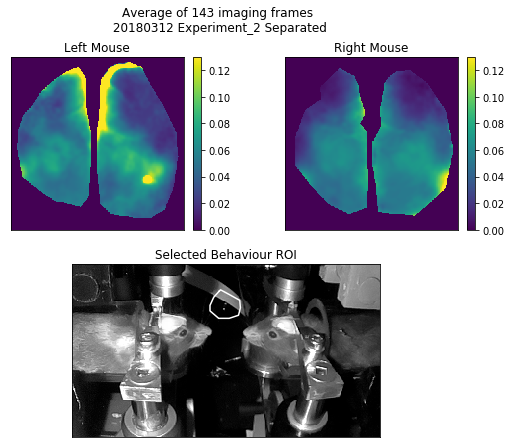

In [77]:
plt.figure(figsize=(9, 7))

plt.suptitle(
    "Average of {} imaging frames\n {}".format(
        str(numpy.shape(above_threshold)[0]), date+" "+experiment + " Separated"
    )
)
plt.subplot(221)
plt.title("Left Mouse")
plt.imshow(l_gtm, cmap='viridis', vmin=0.00, vmax=0.13)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks([])
plt.yticks([])

plt.subplot(222)
plt.title("Right Mouse")
plt.imshow(r_gtm, cmap='viridis', vmin=0.00, vmax=0.13)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks([])
plt.yticks([])

plt.subplot(212)
plt.title("Selected Behaviour ROI")
plt.imshow(behaviour_frames[3217], cmap='gray', vmin=0, vmax=255)
plt.xticks([])
plt.yticks([])
grad_roi.displayROI()

plt.savefig(directory+experiment+"whisker_triggered_map.svg")

# Left and right GTM ROIs

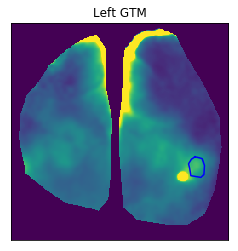

In [78]:
%matplotlib qt
plt.title('Left GTM')
plt.imshow(l_gtm, cmap='viridis', vmin=0.0, vmax=0.15)
l_gtm_roi = RoiPoly(color='b')

%matplotlib inline
plt.title('Left GTM')
plt.imshow(l_gtm, cmap='viridis', vmin=0.0, vmax=0.15)
plt.xticks([])
plt.yticks([])
l_gtm_roi.display_roi()

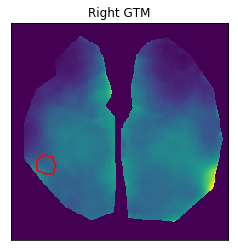

In [83]:
%matplotlib qt
plt.title('Right GTM')
plt.imshow(r_gtm, cmap='viridis', vmin=0.0, vmax=0.15)
r_gtm_roi = RoiPoly(color='r')

%matplotlib inline
plt.title('Right GTM')
plt.imshow(r_gtm, cmap='viridis', vmin=0.0, vmax=0.15)
plt.xticks([])
plt.yticks([])
r_gtm_roi.display_roi()

## Temporal mean of signal in ROI

In [81]:
l_calcium_signal = numpy.mean(
    l_mouse_frames[:, l_gtm_roi.get_mask(l_mouse_frames[0])], 
    axis=1
)
r_calcium_signal = numpy.mean(
    r_mouse_frames[:, r_gtm_roi.get_mask(r_mouse_frames[0])], 
    axis=1
)

exp_duration = l_calcium_signal.shape[0]/IMAGING_FRAMERATE
signal_x_axis = numpy.linspace(0, exp_duration, l_calcium_signal.shape[0])

## Plot Whisking triggered map

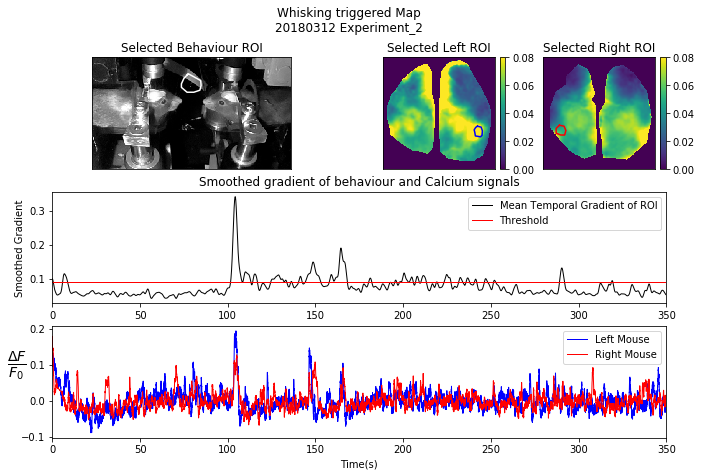

In [107]:
plt.figure(figsize=(11,7))
plt.suptitle("Whisking triggered Map\n"+date+" "+experiment)


plt.subplot(321)
plt.title("Selected Behaviour ROI")
plt.imshow(behaviour_frames[3217], cmap='gray', vmin=0.0, vmax=255)
plt.xticks([])
plt.yticks([])
grad_roi.display_roi()

plt.subplot(343)
plt.title("Selected Left ROI")
plt.imshow(l_gtm, vmin=0.0, vmax=0.08, cmap='viridis')
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks([])
plt.yticks([])
l_gtm_roi.display_roi()

plt.subplot(344)
plt.title("Selected Right ROI")
plt.imshow(r_gtm, vmin=0.0, vmax=0.08, cmap='viridis')
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks([])
plt.yticks([])
r_gtm_roi.display_roi()


plt.subplot(312)
plt.title("Smoothed gradient of behaviour and Calcium signals")
plt.plot(
    signal_x_axis, 
    roi_gradient_signal, 
    color='k', 
    linewidth=1, 
    label='Mean Temporal Gradient of ROI'
)
plt.xlim(signal_x_axis[0], signal_x_axis[-1])
plt.ylabel("Smoothed Gradient")
plt.axhline(SIGMA*signal_std, color='r', linewidth=1, label='Threshold')
plt.legend()

plt.subplot(313)
plt.plot(
    signal_x_axis, 
    l_calcium_signal, 
    linewidth=1, 
    color='b', 
    label='Left Mouse'
)
plt.plot(
    signal_x_axis, 
    r_calcium_signal, 
    linewidth=1, 
    color='r', 
    label='Right Mouse'
)
plt.xlim(signal_x_axis[0], signal_x_axis[-1])
plt.ylabel(r"$\frac{\Delta F}{F _{0}}$", rotation=0, size=20)
plt.xlabel("Time(s)")

plt.legend()
#plt.savefig(directory+experiment+"whisker_triggered_map_with_signals.svg")

## Make video from selected behaviour frames

In [111]:
im_frame = numpy.zeros((256, 256))
beh_frame = numpy.zeros((180, 320))

FFMpegWriter = Animation.writers["ffmpeg"]
metadata = dict(
    title=directory + experiment,
    artist="Fed",
    comment="10Hz_playback",
)
writer = FFMpegWriter(fps=10, metadata=metadata)
fig = plt.figure(figsize=(10, 8))


ax3 = fig.add_subplot(3, 1, 1)
ax3.set_title("Behaviour Frames")
ax3.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
beh_frame = behaviour_frames[above_threshold[0][0]]
beh_image = ax3.imshow(
    beh_frame, cmap="gray", vmin=0, vmax=255
)
grad_roi.displayROI()


ax1 = fig.add_subplot(3, 2, 3)
ax1.set_title("Left Ca Frames")
ax1.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
im_frame = l_gtm
im_LM_ca = ax1.imshow(
    im_frame, cmap="viridis", vmin=0, vmax=0.13
)
cbar = fig.colorbar(im_LM_ca)

ax2 = fig.add_subplot(3, 2, 4)
ax2.set_title("Right Ca Frames")
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
im_frame = r_gtm
im_RM_ca = ax2.imshow(
    im_frame, cmap="viridis", vmin=0, vmax=0.13
)
cbar = fig.colorbar(im_RM_ca)


ax4 = fig.add_subplot(3, 2, 5)
ax4.set_title("Left GTM")
ax4.get_yaxis().set_visible(False)
ax4.get_xaxis().set_visible(False)
im_frame = l_gtm
im_left_gtm = ax4.imshow(
    im_frame, cmap="viridis", vmin=0, vmax=0.13
)
cbar = fig.colorbar(im_left_gtm)

ax5 = fig.add_subplot(3, 2, 6)
ax5.set_title("Right GTM")
ax5.get_yaxis().set_visible(False)
ax5.get_xaxis().set_visible(False)
im_frame = r_gtm
im_right_gtm = ax5.imshow(
    im_frame, cmap="viridis", vmin=0, vmax=0.13
)
cbar = fig.colorbar(im_right_gtm)


print("Writing frames...")
with writer.saving(
    fig,
    "video.mp4",
    # directory+experiment+l_mouse_processed_file.split('/')[-1]+"_behaviour_frames_GTM_LM_body.mp4",
    100,
):
    for i in above_threshold[0]:
        ax1.set_title(
            "Seed Map %s/%s"
            % (str(i), str(full_distance_array.shape[0]))
        )
        beh_frame = behaviour_frames[i]
        beh_image.set_data(beh_frame)
        im_frame = l_mouse_frames[i]
        im_frame[~left_mouse_mask] = -100
        im_LM_ca.set_data(im_frame)
        im_frame = r_mouse_frames[i]
        im_frame[~r_mouse_mask] = -100
        im_RM_ca.set_data(im_frame)
        writer.grab_frame()
print("Done!")

RuntimeError: Requested MovieWriter (ffmpeg) not available

## Extracting 75 percentile frames above threshold

In [ ]:
SIGMA = 2
grad_mask = grad_roi.getMask(behaviour_frames[0])
roi_gradient_signal = gaussian_filter(
    numpy.abs(
        numpy.gradient(
            numpy.mean(
                behaviour_frames[:, grad_mask], axis=1
            )
        )
    ),
    20,  # sigma
)
signal_std = numpy.std(roi_gradient_signal)
signal_mean = numpy.mean(roi_gradient_signal)
signal_threshold = signal_mean + SIGMA * signal_std

subtract_grad_mask = subtract_grad_roi.getMask(
    behaviour_frames[0]
)
subtract_roi_gradient_signal = gaussian_filter(
    numpy.abs(
        numpy.gradient(
            numpy.mean(
                behaviour_frames[:, subtract_grad_mask],
                axis=1,
            )
        )
    ),
    20,  # sigma
)

subtract_signal_std = numpy.std(
    subtract_roi_gradient_signal
)
subtract_signal_mean = numpy.mean(
    subtract_roi_gradient_signal
)
subract_threshold = (
    subtract_signal_mean + SIGMA * subtract_signal_std
)


plt.figure()
plt.subplot(211)
plt.plot(
    roi_gradient_signal,
    color="k",
    label="Mean Temporal Gradient of ROI",
)
plt.axhline(signal_threshold, color="r", label="Threshold")
plt.legend()
plt.subplot(212)
plt.plot(
    subtract_roi_gradient_signal,
    color="k",
    label="Mean Temporal Gradient of ROI",
)
plt.axhline(subract_threshold, color="r", label="Threshold")
plt.legend()

indeces = numpy.where(
    roi_gradient_signal[100:] >= signal_threshold
)
indeces = numpy.asarray(indeces)
indeces += 100

subtract_indeces = numpy.where(
    subtract_roi_gradient_signal[100:] >= subtract_threshold
)
subtract_indeces = numpy.asarray(subtract_indeces)
subtract_indeces += 100

In [109]:
percentile_75 = numpy.array(
    [
        numpy.percentile(l_calcium_signal[indeces], 75),
        numpy.percentile(r_calcium_signal[indeces], 75),
    ]
)

if "12mm" in l_green_frame_file:
    numpy.save(
        directory
        + experiment
        + "75th_percentile_calcium_together.npy",
        percentile_75,
    )
    print("Saved 12mm file")

NameError: name 'indeces' is not defined

In [ ]:
pruned_indeces = [[]]
for index in indeces[0]:
    add = True
    for subtract_index in subtract_indeces[0]:
        if index == subtract_index:
            add = False
    if add:
        pruned_indeces[0].append(index)

In [ ]:
left_gtm = numpy.mean(left_mouse_frames[pruned_indeces], axis=0)
right_gtm = numpy.mean(right_mouse_frames[pruned_indeces], axis=0)


left_gtm[~left_mouse_mask] = -100
right_gtm[~right_mouse_mask] = -100

In [ ]:
plt.figure(figsize=(9, 7))
# plt.figure(figsize=(8, 4))
plt.suptitle(
    "Average of %s imaging frames\n"
    % str(np.shape(pruned_indeces)[1])
    + date
    + " "
    + experiment[:-1]
    + " Separated"
)
plt.subplot(221)
plt.title("Left Mouse")
plt.imshow(left_gtm, cmap="viridis", vmin=0.00, vmax=0.07)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks([])
plt.yticks([])

plt.subplot(222)
plt.title("Right Mouse")
plt.imshow(right_gtm, cmap="viridis", vmin=0.00, vmax=0.15)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks([])
plt.yticks([])

plt.subplot(212)
plt.title("Selected Behaviour ROI")
plt.imshow(
    behaviour_frames[3217], cmap="gray", vmin=0, vmax=255
)
plt.xticks([])
plt.yticks([])
grad_roi.displayROI()

plt.savefig(
    directory + experiment + "whisker_triggered_map.svg"
)